In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
import json
%matplotlib inline

In [2]:
class TableDetector:

    def __init__(self, verbose=False, strip_height=50, w_max_pool=50, min_col_width=50, ratio_clip_max=0.8):
        self.verbose = verbose
        self.state = 'Table_Search'
        self.state_machine = {'Table_Search':self.table_search, 
                              'Candidate_Table': self.candidate_table, 
                              'Table_Registered':self.table_registered, 
                              'Confirm_Table_End':self.confirm_table_end}
        self.tables = []
        self.reset_table_info()
        self.strip_height = strip_height
        self.w_max_pool = w_max_pool
        self.min_col_width = min_col_width
        self.ratio_clip_max = ratio_clip_max
        
    def reset_table_info(self):
        
        self.table_info = {}
        self.col_positions = []
        
    def table_search(self):
        '''
        if(self.verbose):
            print('Table_Search')
        '''
        if len(self.col_positions) > 0:      
            self.state = 'Candidate_Table'
            self.table_info['table_start'] = self.start
            self.table_info['col_positions'] = self.col_positions
            self.n_cols = len(self.col_positions)
            
        return
    
    def candidate_table(self):
        '''
        if(self.verbose):
            print('Candidate_Table')
        '''
        if len(self.col_positions) > 0 and len(self.col_positions) == self.n_cols:      
            self.state = 'Table_Registered'
        else:
            self.state = 'Table_Search'
            self.reset_table_info()
        return
    
    def table_registered(self):
        '''
        if(self.verbose):
            print('Table_Registered')
        '''
        #if len(self.col_positions) == 0 or len(self.col_positions) != self.n_cols:
        if len(self.col_positions) == 0:
            self.state = 'Confirm_Table_End'
        return
    def confirm_table_end(self):
        '''
        if(self.verbose):
            print('Confirm_Table_End')
        '''
        #if len(self.col_positions) == 0 or len(self.col_positions) != self.n_cols:
        if len(self.col_positions) != self.n_cols:
            self.state = 'Table_Search'
            self.table_info['table_end'] = self.end
            self.tables.append(self.table_info)
            self.reset_table_info()
        else:
            self.state = 'Table_Registered'
        return
    
    def remove_false_cols(self, grads):
        #self.min_col_width = 50
        # Get all posititions of col starts

        col_starts = np.squeeze(np.argwhere(grads==1))
        # If dist between 2 1's < min_col_width--> set all to zeros until next 1 pos
        prev_pos = col_starts[0]
        for idx, pos in enumerate(col_starts):
            if idx > 0:
                dist = pos - prev_pos
                if dist < self.min_col_width:  
                    grads[pos] = 0
                else:                   
                    prev_pos = pos

        return grads   
 
    def remove_consecutive(self, input): 
        # Get 1's pos
        ones = np.squeeze(np.argwhere(input == 1))
        # Get -1's pos
        neg_ones = np.squeeze(np.argwhere(input == -1))
        # Alternate from 1's and -1's. Always start by 1's
        result = []
        positive = True
        next_pos = 0
        for i in range(len(ones)):
            if positive:
                result.append(ones[next_pos])
                positive = False
                curr_pos = next_pos

                next_pos = np.squeeze(np.argwhere(neg_ones > ones[curr_pos])).tolist()# Alternate to the pos in neg_ones > curr_pos value in ones
                if isinstance(next_pos, list):
                    if len(next_pos) > 0:
                        next_pos = next_pos[0]
                    else:
                        break
                else:
                    next_pos = next_pos
            else:
                result.append(neg_ones[next_pos])
                positive = True
                curr_pos = next_pos

                next_pos = np.squeeze(np.argwhere(ones > neg_ones[curr_pos])).tolist()
                if isinstance(next_pos, list):
                    if len(next_pos) > 0:
                        next_pos = next_pos[0]
                    else:
                        break
                else:
                    next_pos = next_pos

        mask = np.zeros(len(input), dtype=int)
        if(len(result) > 0):
            mask[np.array(result)] = input[np.array(result)]

        return mask 
    
    def maxpool1D(self, h, w):

        n_w = int(len(h)/w)
        h_maxes = np.zeros(len(h))
        for i in range(n_w):

            h_maxes[i*w:(i+1)*w] = max(h[i*w:(i+1)*w]) 
            
        return h_maxes    
    
    def clean_grads(self, grads):
        # TODO: outliers removal

        # Adaptive threshold = max*ratio       
        thresh = np.max(grads)*self.ratio_clip_max   

        # Filter pos values
        filter_pos_idx = np.squeeze(np.argwhere(np.logical_and((grads > 0), (grads <= thresh))))
        grads[filter_pos_idx] = 0

        # Filter neg values
        filter_neg_idx = np.squeeze(np.argwhere(np.logical_and((grads < 0), (grads >= -thresh))))
        grads[filter_neg_idx] = 0

        # Normalize thr grads to 1/-1
        grads[grads < 0] = -1
        grads[grads > 0] = 1

        # Remove consecutive 1's or -1's
        #grads = self.remove_consecutive(grads)

        return grads  
    
    def preprocess_row(self, img_strip):

        # 1. Histo projection
        h_all = np.sum(img_strip, axis=0)
        # 2. Maxpool1D
        h_maxes = self.maxpool1D(h_all, w=self.w_max_pool)
        # 3. Gradients
        g = np.gradient(h_maxes)
        # 4. Clean grads
        g_clean = self.clean_grads(g.copy())   
        
        #g_clean = g
        if verbose:
            self.g_clean = g_clean
            
        
        return g_clean
    
    def check_row_pattern(self, row_grads):

        if len(np.argwhere(row_grads==1)) >= 2:

            # If dist between 2 1's < min_col_width--> set all to zeros
            row_grads = self.remove_false_cols(row_grads)
            
            # Count 1's => 2
            if len(np.argwhere(row_grads==1)) >= 2:
                col_positions = np.squeeze(np.argwhere(row_grads==1))                   

            else:
                col_positions = []
        else:
            col_positions = []

        return col_positions
    
    def row_pattern_detect(self, img_strip):
        g_clean = self.preprocess_row(img_strip)
        col_positions = self.check_row_pattern(g_clean)

        self.col_positions = col_positions

        return col_positions
    
    def run(self, img):
        H, W = img.shape
        n_strips = int(np.floor(H/self.strip_height))
        
        for i in range(n_strips):
            self.start = i*self.strip_height
            self.end = self.start + self.strip_height
            img_strip = img[self.start:self.end, :] 
            col_positions = self.row_pattern_detect(img_strip)
            self.state_machine[self.state]()
            if self.verbose and i == 24:
                fig = plt.figure()    
                # Show the orig image with the strip on col 1
                ax = fig.add_subplot(211)
                rect = patches.Rectangle((0,self.end), W, self.strip_height, linewidth=1, edgecolor='r', facecolor='none')
                n_cols = len(col_positions)
                
                ax.add_patch(rect)
                ax.text(10,10,str(n_cols))
                ax.imshow(img, cmap='gray')

                # Show next the cleaned up grad or histogram
                ax = fig.add_subplot(221)
                ax.plot(self.g_clean)                
            
        return self.tables
   
    def visualize_tables(self, img_orig, file_name):
        tables = self.tables
        tables_img = img_orig
        line_width = 10
        fig = plt.figure()
        for table in tables:
            #table_start = table['table_start'] - self.strip_height
            #table_end = table['table_end'] - self.strip_height
            table_start = table['table_start'] - self.strip_height
            table_end = table['table_end'] - self.strip_height
            # Last colomn boundary = min(img_boundary, last_col_start + spacing of the previous colomn)
            #last_col = min(tables_img.shape[1], table['col_positions'][-1] + (table['col_positions'][-1] - table['col_positions'][-2]))
            last_col = tables_img.shape[1] - table['col_positions'][0]
            # Draw table boundaries
            tables_img[table_start-line_width:table_start+line_width, table['col_positions'][0] : last_col] = 0
            tables_img[table_end-line_width:table_end+line_width, table['col_positions'][0] : last_col] = 0
            # Draw cols
            for col in table['col_positions']:

                tables_img[table_start:table_end, col-line_width:col+line_width] = 0
            # Left boundary
            tables_img[table_start:table_end, last_col-line_width:last_col+line_width] = 0
        plt.imshow(tables_img, cmap='gray')
        plt.imsave(file_name + '_table.jpg', tables_img, cmap='gray')      
        return
    
    def save_json(self, file_name):
            
        output_file = open(file_name + '.json', 'w')
        for table in self.tables:
            print(table)
            json.dump(table, output_file) 
            output_file.write("\n")  
            
        return    
       

In [3]:

#dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"
dat_path = "../../../dat"

In [4]:
#file_name = 'Page 3.jpg' # OK
#file_name = 'Page 5.jpg' # OK
#file_name = 'Page 7.jpg' # OK
#file_name = 'Page 8.jpg' # NOK
#file_name = 'Page 3.tiff' # NOK
file_name = 'Page 3_mod.tiff' # NOK
#file_name = 'Page 3_mod_no_table.tiff' # NOK

img_orig = cv2.imread(os.path.join(dat_path, file_name), 0)
img = (255 - img_orig)/255
img = img[:, :-100]

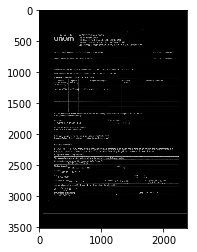

In [5]:
plt.imshow(img,cmap='gray')

In [6]:
img.shape

(3508, 2379)

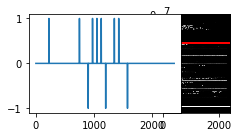

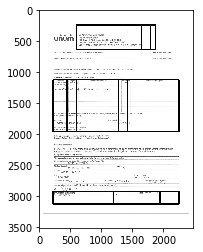

In [7]:
verbose = True
tables_detector = TableDetector(verbose, strip_height=40, w_max_pool=75, min_col_width=50, ratio_clip_max=0.1)
tables = tables_detector.run(img)
tables_detector.visualize_tables(img_orig, file_name)
#tables_detector.save_json(file_name)

In [8]:
tables

[{'table_start': 280,
  'col_positions': array([ 599, 1649, 1799]),
  'table_end': 680},
 {'table_start': 1160,
  'col_positions': array([ 224,  449,  599, 1274, 1424]),
  'table_end': 2000},
 {'table_start': 2960,
  'col_positions': array([ 224, 1199, 1949]),
  'table_end': 3160}]

In [9]:
from pdftabextract.common import read_xml, parse_pages